# PCA on the original and reproduced specta

Now we want to see whether the model is able to reproduce the properties of the spectra in a way that they are distinguishable from other spectra. We will perform a PCA on the real data (not QC's) and on the reproduced spectra of the real data. Then we plot 10 real spectra examples and their reproduced versions in the PCA-plot and see if we can relate the spectra pairs to each other. They should be closer to each other than to other pairs in the plot.

In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
gen = np.loadtxt("spectra_no_qcs.txt", delimiter=",")
shp = gen.shape

#splitting data into train and test set, we only want 10 test spectra for the PCA
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=10, random_state=42, shuffle=True, stratify=None)

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
test_scaled = standardscaler.fit_transform(test)
train = standardscaler.fit_transform(train)

In [86]:
activation = "elu"
regularizer = keras.regularizers.L1L2(l1=0.01, l2=0.01)

inputlayer = layers.Input(shape=train.shape[1])
e2 = layers.Dense(500, activation=activation)(inputlayer)
e3 = layers.Dense(250, activation=activation)(e2)
dropout = layers.Dropout(0.3)(e3)
e4 = layers.Dense(100)(dropout)

encoded = layers.Dense(50)(e4)

d1 = layers.Dense(100, activation=activation)(encoded)
d2 = layers.Dense(250, activation=activation)(d1)
d3 = layers.Dense(500, activation=activation)(d2)
outputlayer = layers.Dense(1101, activation="linear")(d3)

model = keras.models.Model(inputlayer, outputlayer, name="autoencoder_dense_v1")

print(model.summary())

Model: "autoencoder_dense_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1101)]            0         
_________________________________________________________________
dense_32 (Dense)             (None, 500)               551000    
_________________________________________________________________
dense_33 (Dense)             (None, 250)               125250    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_35 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_36 (Dense)             (None, 100)      

In [87]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

In [88]:
results = model.fit(train, train,
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[earlystopping, rl_on_plateau])

Train on 6535 samples, validate on 727 samples
Epoch 1/50
6535/6535 [==============================] - 1s 217us/sample - loss: 0.3412 - val_loss: 0.1110
Epoch 2/50
6535/6535 [==============================] - 1s 108us/sample - loss: 0.1388 - val_loss: 0.0805
Epoch 3/50
6535/6535 [==============================] - 1s 112us/sample - loss: 0.1059 - val_loss: 0.0691
Epoch 4/50
6535/6535 [==============================] - 1s 111us/sample - loss: 0.0881 - val_loss: 0.0438
Epoch 5/50
6535/6535 [==============================] - 1s 111us/sample - loss: 0.0813 - val_loss: 0.0599
Epoch 6/50
6528/6535 [============================>.] - ETA: 0s - loss: 0.0819
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
6535/6535 [==============================] - 1s 125us/sample - loss: 0.0819 - val_loss: 0.0765
Epoch 00006: early stopping


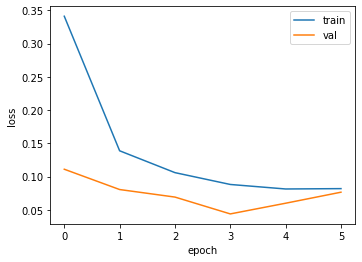

In [89]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [3]:
preds = model.predict(test_scaled, verbose=1)

NameError: name 'model' is not defined

In [2]:
preds_rescaled = standardscaler.inverse_transform(test_scaled)

NameError: name 'preds' is not defined

No handles with labels found to put in legend.


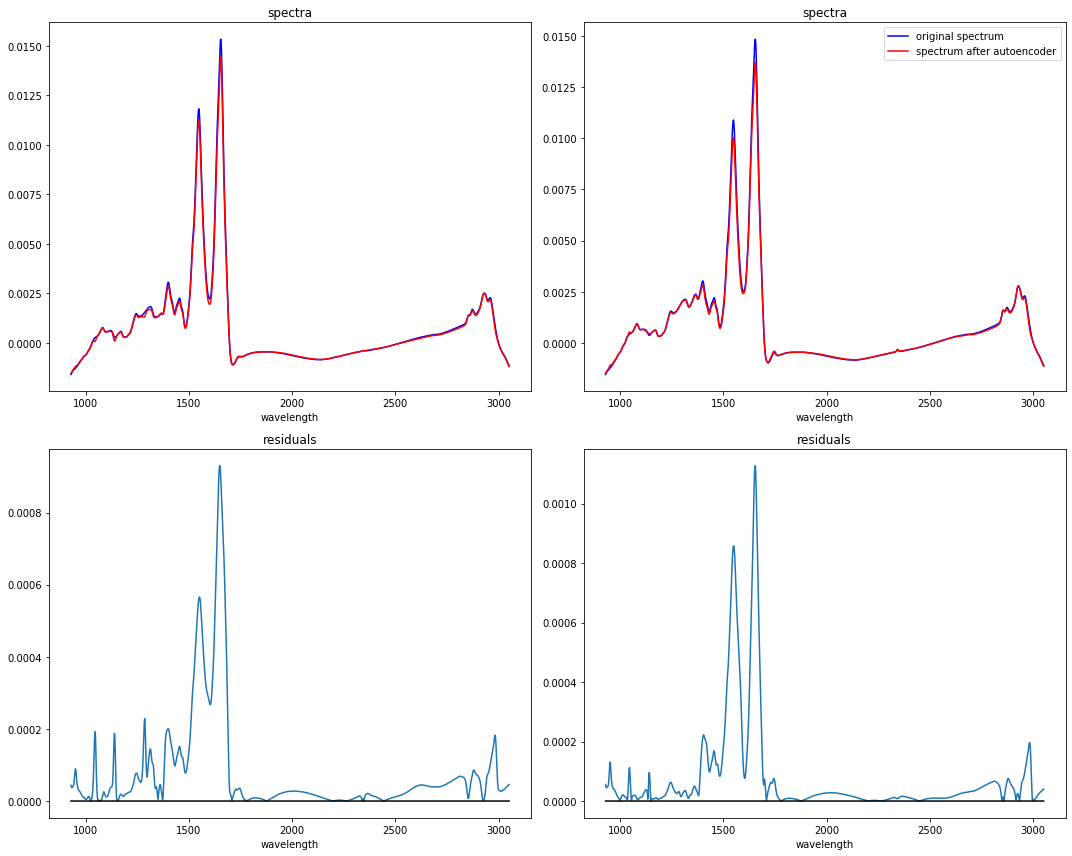

In [92]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[1].legend(loc=1)
    ax1[i].set_xlabel('wavelength')
    ax2[i].set_xlabel('wavelength')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()

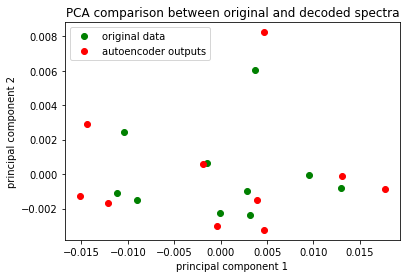

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#performing PCA on the examples
principalComponents = pca.fit_transform(test)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#passing the examples to the autoencoder and performing PCA again
principalComponents_preds = pca.fit_transform(preds_rescaled)
principalDf_preds = pd.DataFrame(data = principalComponents_preds, columns = ['principal component 1', 'principal component 2'])

#plotting the results
xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_preds = list(principalDf_preds["principal component 1"])
yaxis_preds = list(principalDf_preds["principal component 2"])

plt.plot(xaxis, yaxis, 'go', label = "original data ")
plt.plot(xaxis_preds, yaxis_preds, 'ro', label = "autoencoder outputs")
plt.title("PCA comparison between original and decoded spectra")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()

PCA centers the spectra. In principal, the model can reproduce the shape of the PCA but maybe the model can be adapted to perform even better regression.

(20, 1101)
(10, 1101)
(10, 1101)


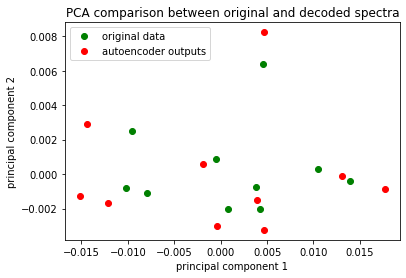

In [84]:
test_preds_together = np.concatenate((preds_rescaled, test))

#normalizing the spectra to see if the pairs in the PCA get closer.
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit_transform(test_preds_together)
test_normalized = test_preds_together[:10]
preds_normalized = test_preds_together[10:]
print(test_preds_together.shape)
print(test_normalized.shape)
print(preds_normalized.shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

"""
#performing PCA on the examples
principalComponents = pca.fit_transform(test_normalized)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#passing the examples to the autoencoder and performing PCA again
principalComponents_preds = pca.fit_transform(preds_normalized)
principalDf_preds = pd.DataFrame(data = principalComponents_preds, columns = ['principal component 1', 'principal component 2'])
"""

#performing PCA on the examples
principalComponents = pca.fit_transform(test_preds_together)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])


#plotting the results
xaxis = list(principalDf["principal component 1"][10:])
yaxis = list(principalDf["principal component 2"][10:])
xaxis_preds = list(principalDf_preds["principal component 1"][:10])
yaxis_preds = list(principalDf_preds["principal component 2"][:10])

plt.plot(xaxis, yaxis, 'go', label = "original data ")
plt.plot(xaxis_preds, yaxis_preds, 'ro', label = "autoencoder outputs")
plt.title("PCA comparison between original and decoded spectra")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()

Normalization didn't work

It seems like the model architecture doesn't work so well on the real data. It was able to reproduce the qcs but now it has reached its limit.